In [2]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv3D,
    MaxPooling3D,
    Flatten,
    Dense,
    BatchNormalization,
    Dropout,
)
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns

# Directory containing the NIfTI files
directory = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT'

# Maximum number of voxels to plot per file to avoid overwhelming
max_voxels_to_plot = 10  # Adjust as needed

# Loop through each file in the directory
for filename in os.listdir(directory.strip()):
    if filename.endswith('.nii') or filename.endswith('.nii.gz'):
        # Construct the full file path
        file_path = os.path.join(directory.strip(), filename)
        
        print(f"\nProcessing file: {filename}")
        
        # Load the NIfTI file
        img = nib.load(file_path)
        data = img.get_fdata()
        
        # Identify non-zero voxels across all time points
        non_zero_voxels = np.any(data != 0, axis=3)  # 3D mask of non-zero voxels
        non_zero_coords = np.argwhere(non_zero_voxels)
        num_non_zero_voxels = len(non_zero_coords)
        
        print(f"Number of non-zero voxels: {num_non_zero_voxels}")
        
        # If no non-zero voxels are found, continue to the next file
        if num_non_zero_voxels == 0:
            print(f"No non-zero voxels found in {filename}. Skipping...")
            continue
        
        # Limit the number of voxels to plot
        num_voxels_to_plot = min(max_voxels_to_plot, num_non_zero_voxels)
        
        # Extract and plot BOLD time series for the selected voxels
        for idx in range(num_voxels_to_plot):
            x, y, z = non_zero_coords[idx]
            
            # Extract the time series for the voxel
            voxel_time_series = data[x, y, z, :]
            
            # Create a time axis based on TR (assuming TR = 1.5s, adjust if different)
            tr = 1.5
            time_points = np.arange(len(voxel_time_series)) * tr
            
            # Improved visualization using Seaborn
            # plt.figure(figsize=(12, 6))
            # sns.set(style='whitegrid')
            # sns.lineplot(x=time_points, y=voxel_time_series, marker='o', linewidth=2.5)
            # plt.title(f'BOLD Time Series at Voxel ({x}, {y}, {z}) in {filename}', fontsize=16)
            # plt.xlabel('Time (s)', fontsize=14)
            # plt.ylabel('Signal Intensity', fontsize=14)
            # plt.xticks(fontsize=12)
            #plt.yticks(fontsize=12)
            # plt.tight_layout()
            



Processing file: s14_run005.nii
Number of non-zero voxels: 187

Processing file: s05_run006.nii
Number of non-zero voxels: 96

Processing file: s14_run004.nii
Number of non-zero voxels: 187

Processing file: s14_run006.nii
Number of non-zero voxels: 187

Processing file: s05_run004.nii
Number of non-zero voxels: 96

Processing file: s05_run005.nii
Number of non-zero voxels: 96

Processing file: s14_run003.nii
Number of non-zero voxels: 187

Processing file: s05_run001.nii
Number of non-zero voxels: 96

Processing file: s14_run002.nii
Number of non-zero voxels: 187

Processing file: s05_run002.nii
Number of non-zero voxels: 96

Processing file: s05_run003.nii
Number of non-zero voxels: 96


Scan entire dataset for non-zero voxels - BOLD

In [90]:
# Find non-zero voxels across the entire dataset
non_zero_indices_full = np.nonzero(data)

# Convert indices to list of coordinates (x, y, z, t)
non_zero_coordinates = list(zip(non_zero_indices_full[0], non_zero_indices_full[1], non_zero_indices_full[2], non_zero_indices_full[3]))

# Optionally, print or analyze these coordinates
print("Non-zero voxel coordinates (x, y, z, t):", non_zero_coordinates)


Non-zero voxel coordinates (x, y, z, t): [(35, 55, 8, 0), (35, 55, 8, 1), (35, 55, 8, 2), (35, 55, 8, 3), (35, 55, 8, 4), (35, 55, 8, 5), (35, 55, 8, 6), (35, 55, 8, 7), (35, 55, 8, 8), (35, 55, 8, 9), (35, 55, 8, 10), (35, 55, 8, 11), (35, 55, 8, 12), (35, 55, 8, 13), (35, 55, 8, 14), (35, 55, 8, 15), (35, 55, 8, 16), (35, 55, 8, 17), (35, 55, 8, 18), (35, 55, 8, 19), (35, 55, 8, 20), (35, 55, 8, 21), (35, 55, 8, 22), (35, 55, 8, 23), (35, 55, 8, 24), (35, 55, 8, 25), (35, 55, 8, 26), (35, 55, 8, 27), (35, 55, 8, 28), (35, 55, 8, 29), (35, 55, 8, 30), (35, 55, 8, 31), (35, 55, 8, 32), (35, 55, 8, 33), (35, 55, 8, 34), (35, 55, 8, 35), (35, 55, 8, 36), (35, 55, 8, 37), (35, 55, 8, 38), (35, 55, 8, 39), (35, 55, 8, 40), (35, 55, 8, 41), (35, 55, 8, 42), (35, 55, 8, 43), (35, 55, 8, 44), (35, 55, 8, 45), (35, 55, 8, 46), (35, 55, 8, 47), (35, 55, 8, 48), (35, 55, 8, 49), (35, 55, 8, 50), (35, 55, 8, 51), (35, 55, 8, 52), (35, 55, 8, 53), (35, 55, 8, 54), (35, 55, 8, 55), (35, 55, 8, 56),

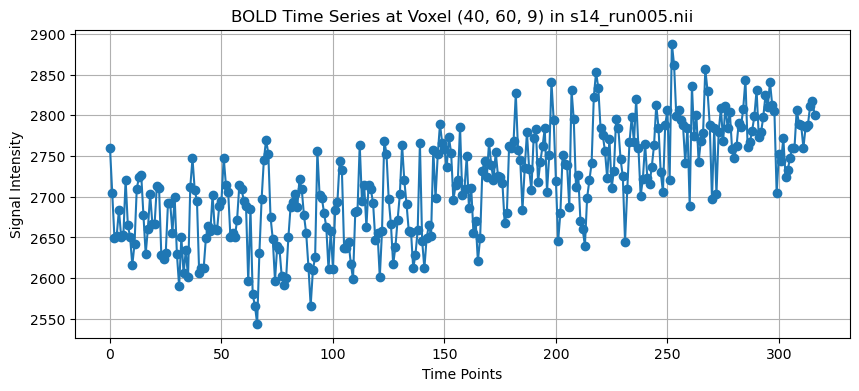

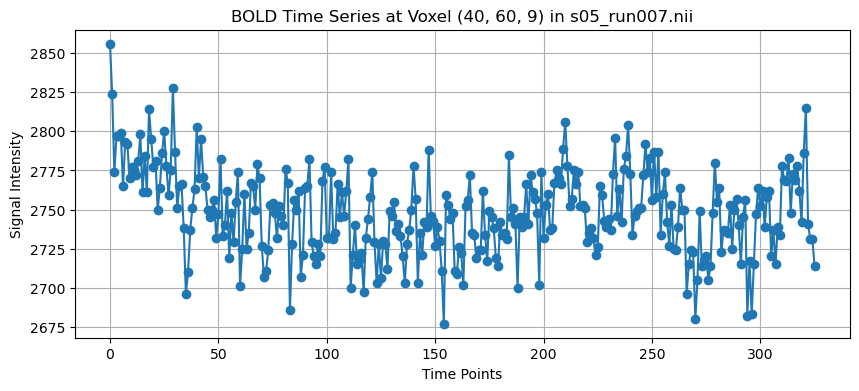

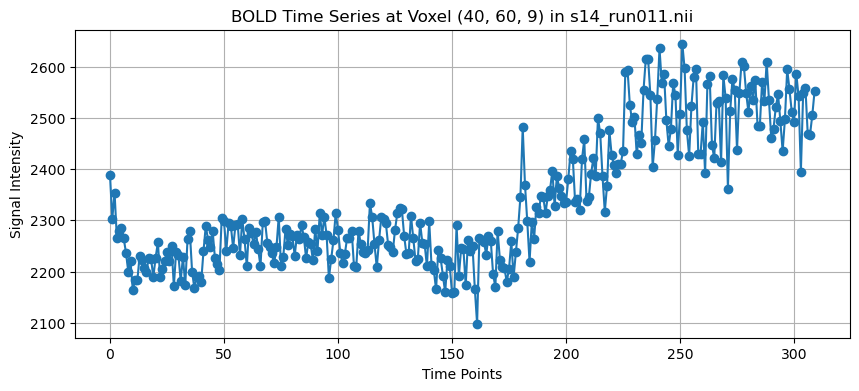

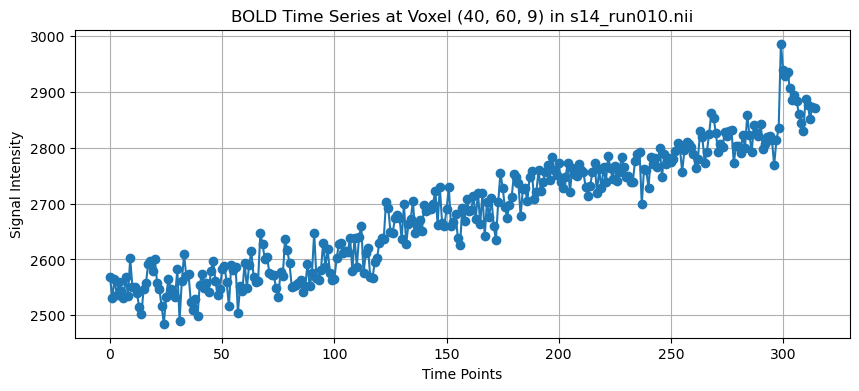

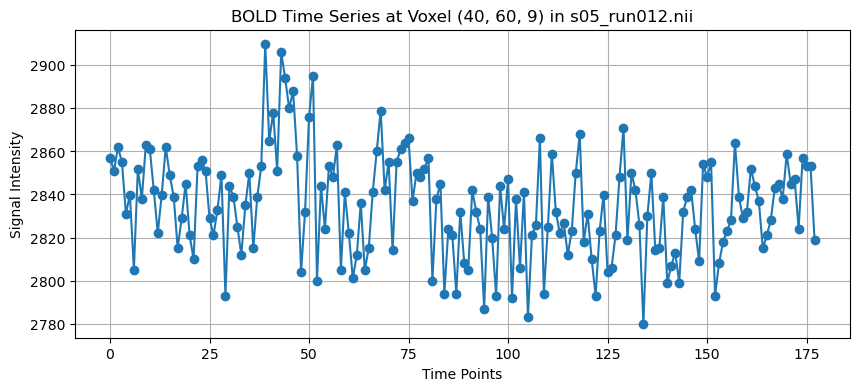

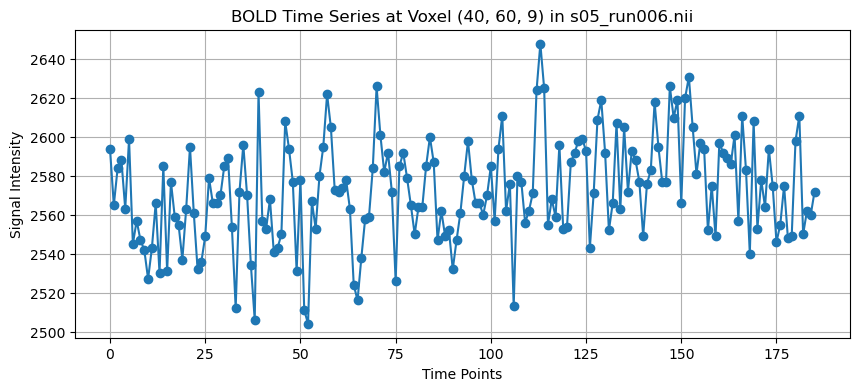

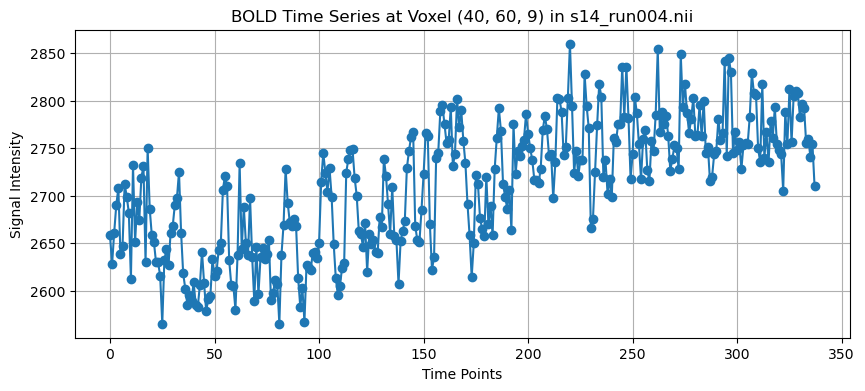

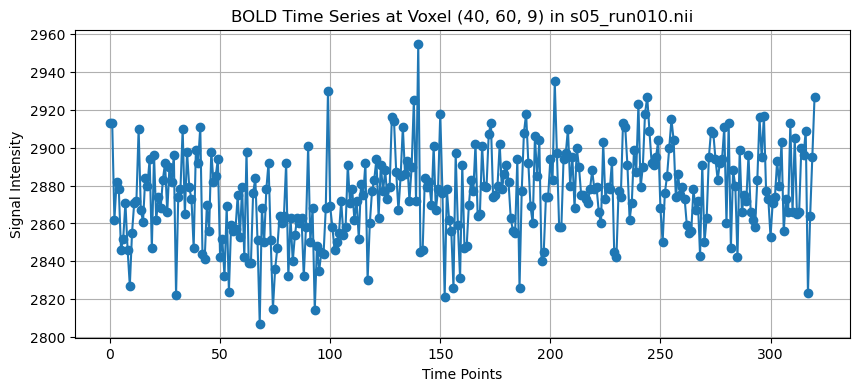

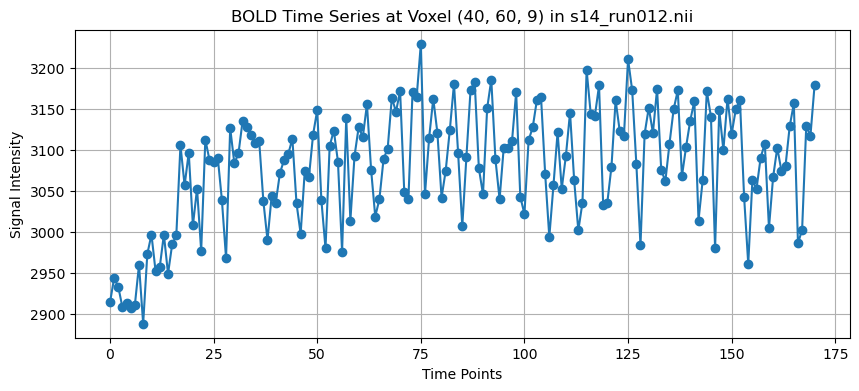

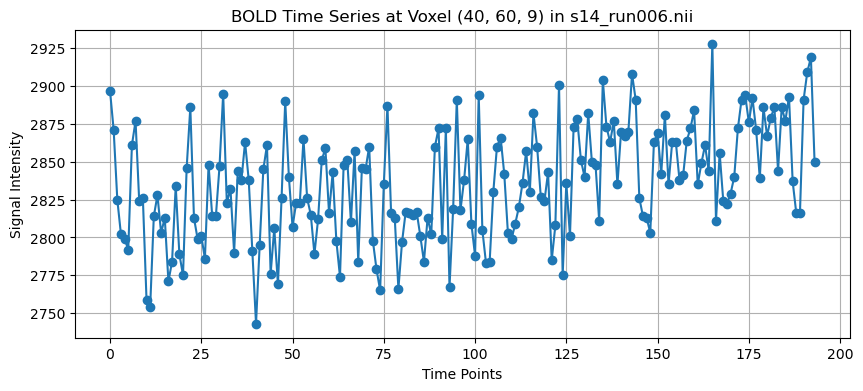

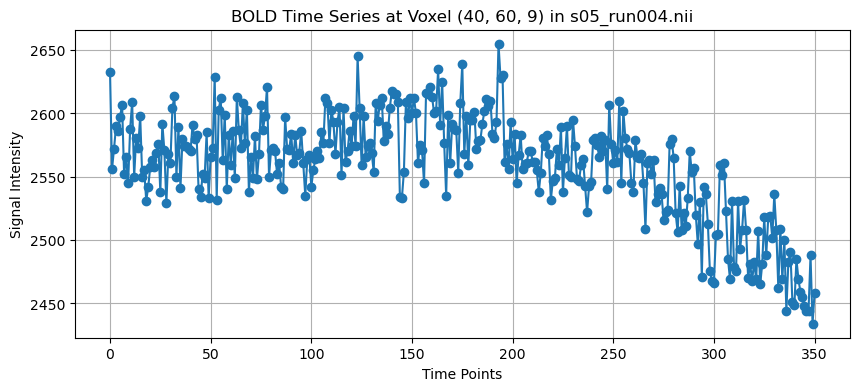

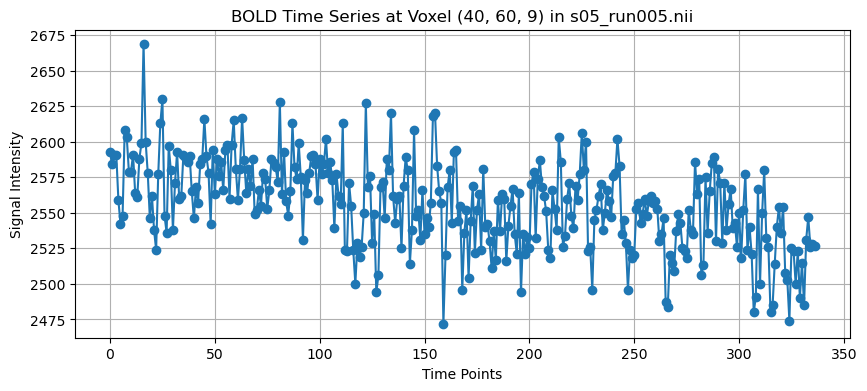

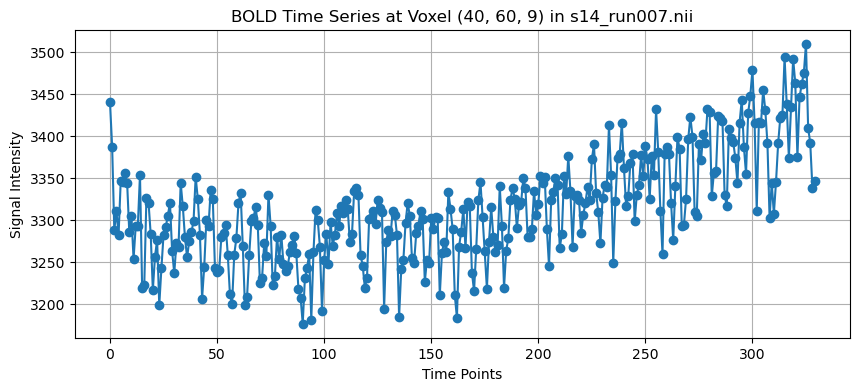

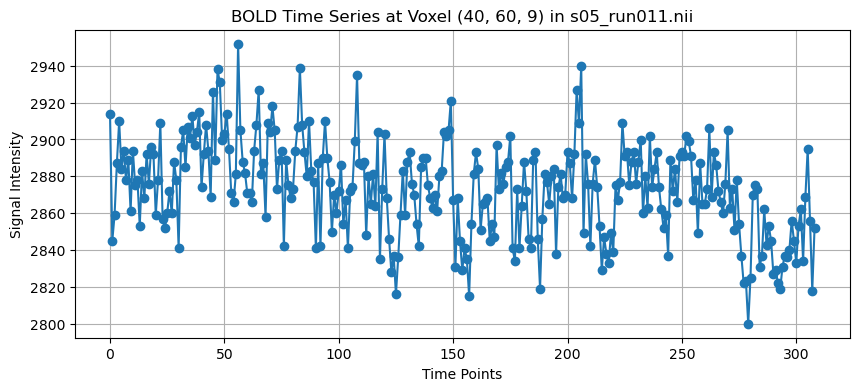

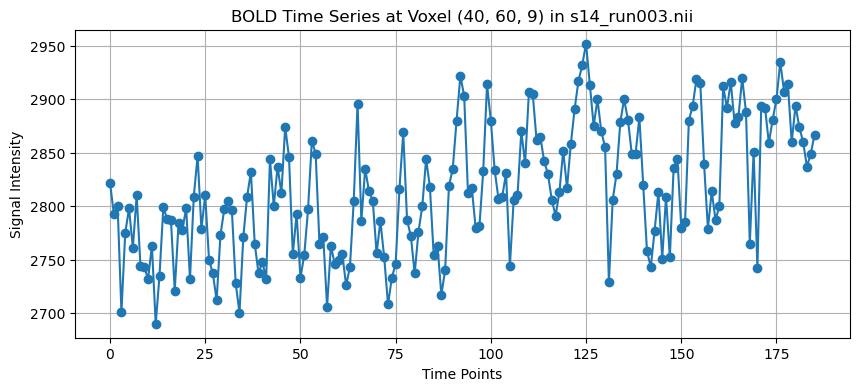

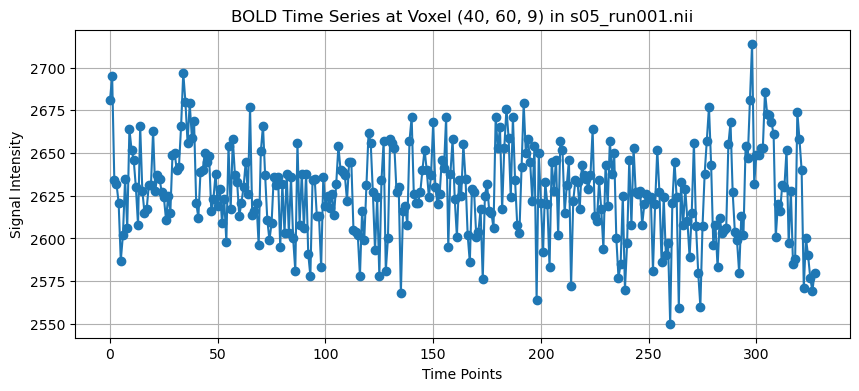

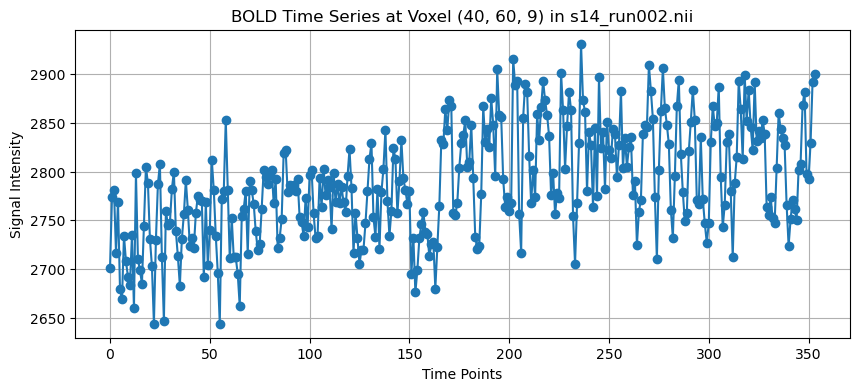

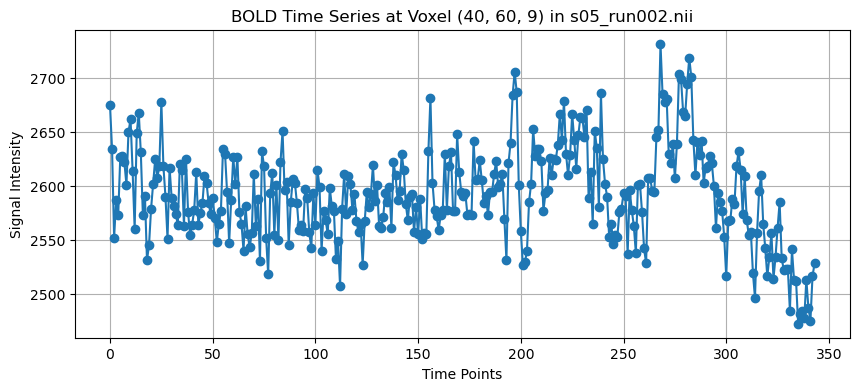

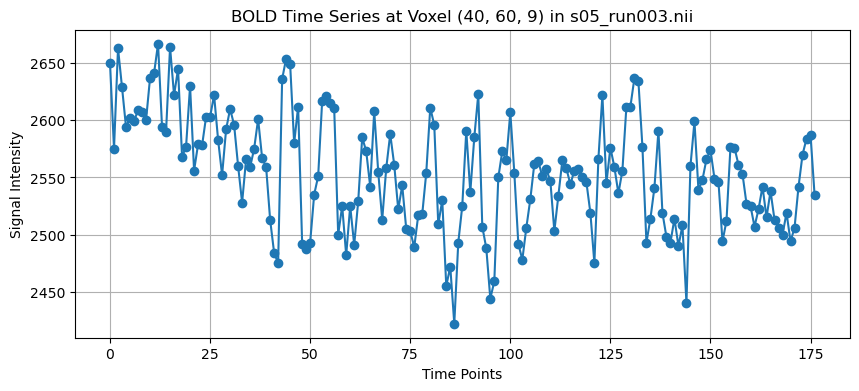

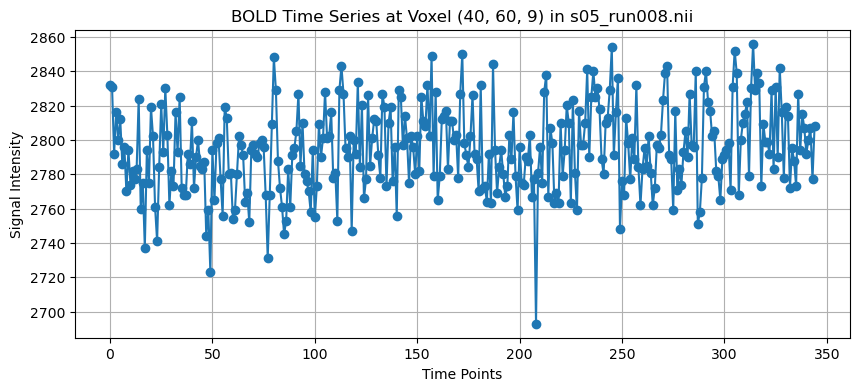

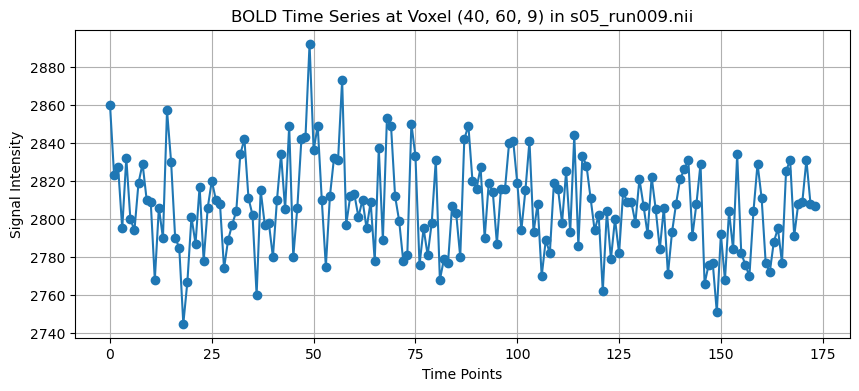

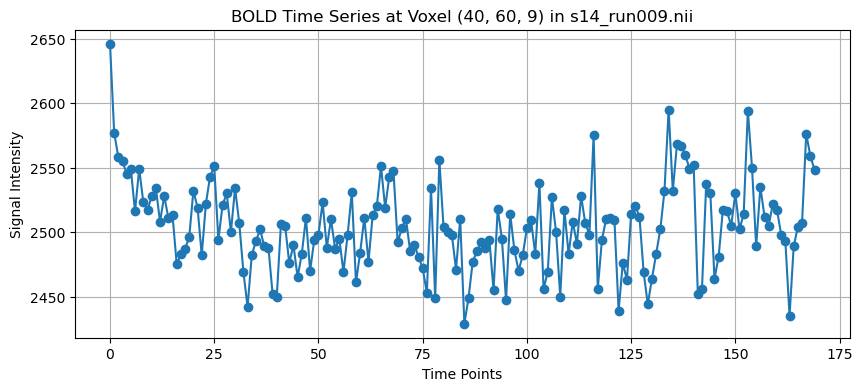

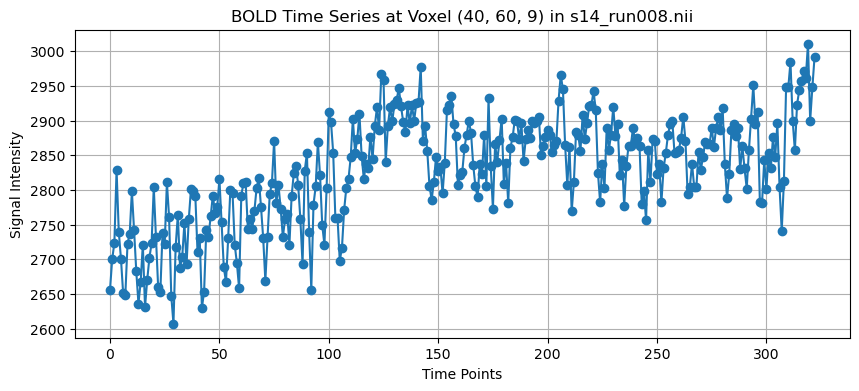

In [4]:
# Directory containing the NIfTI files
directory = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/'

# Voxel coordinates for extracting the BOLD signal
voxel_x, voxel_y, voxel_z = 40, 60, 9  # Select specific voxel of interest

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.nii') or filename.endswith('.nii.gz'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        
        # Load the NIfTI file
        img = nib.load(file_path)
        data = img.get_fdata()

        # Extract the time series for the specified voxel
        voxel_time_series = data[voxel_x, voxel_y, voxel_z, :]

        # Plot the time series
        plt.figure(figsize=(10, 4))
        plt.plot(voxel_time_series, marker='o', linestyle='-')
        plt.title(f'BOLD Time Series at Voxel ({voxel_x}, {voxel_y}, {voxel_z}) in {filename}')
        plt.xlabel('Time Points')
        plt.ylabel('Signal Intensity')
        plt.grid(True)
        plt.show()


Open Field - 6 FOLD - Runs 001 - 006 

Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run001.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run001_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run002.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run002_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run003.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run003_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run004.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run004_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run005.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run005_orientations.csv
Matched: /Users/danielledowe/Deskto

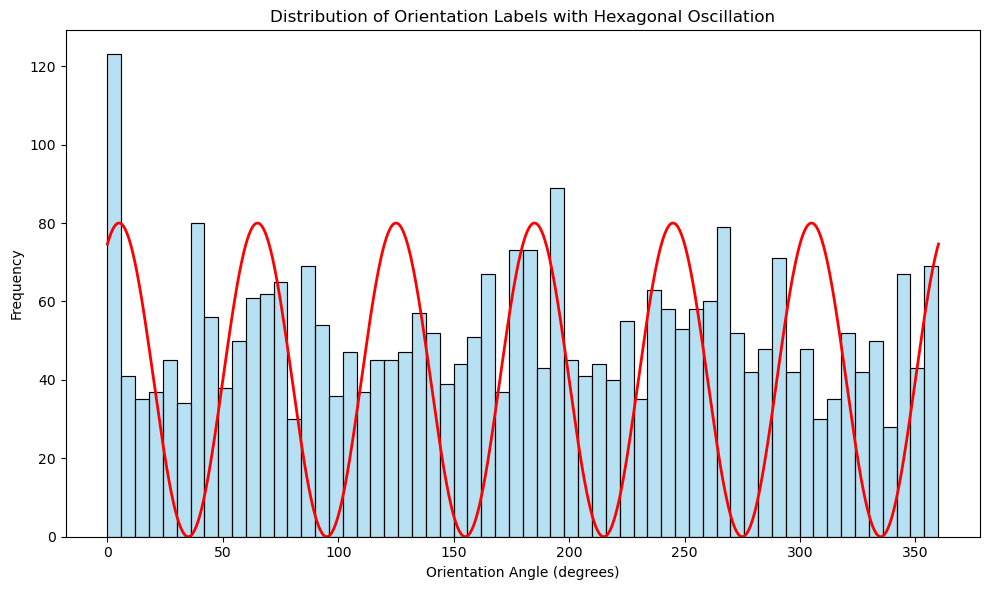


Splitting data into training and testing sets (80% training, 20% testing)...
Number of samples in training set: 2489
Number of samples in testing set: 623

Normalizing fMRI data using z-scoring...
Training data mean: 2.0544428441455103, std: 75.66835283663339
Data normalization complete.

Defining the 3D CNN regression model...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 94, 94, 18, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 18, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 47, 47, 9, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 45, 45, 7, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 7, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 22, 22, 3, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 92928)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,894,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,951,810 (45.59 MB)

 Trainable params: 11,951,618 (45.59 MB)

 Non-trainable params: 192 (768.00 B)

Model compiled successfully with a learning rate of 0.001.

Training the 3D CNN regression model...
Epoch 1/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 790s 2s/step - loss: 232.4496 - mean_absolute_error: 2.9463 - val_loss: 22.4108 - val_mean_absolute_error: 2.7262
Epoch 2/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 800s 2s/step - loss: 1.0001 - mean_absolute_error: 0.6270 - val_loss: 1.0001 - val_mean_absolute_error: 0.6315
Epoch 3/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 769s 2s/step - loss: 1.0001 - mean_absolute_error: 0.6273 - val_loss: 1.0001 - val_mean_absolute_error: 0.6315
Epoch 4/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 784s 2s/step - loss: 1.0001 - mean_absolute_error: 0.6298 - val_loss: 1.0000 - val_mean_absolute_error: 0.6315
Epoch 5/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 763s 2s/step - loss: 1.0000 - mean_absolute_error: 0.6296 - val_loss: 0.9999 - val_mean_absolute_error: 0.6315
Epoch 6/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 1159s 3s/step - loss: 1.0000 - mean_absolute_error: 0.6273 - val_loss: 0.9999 - val_mean_absolute_erro

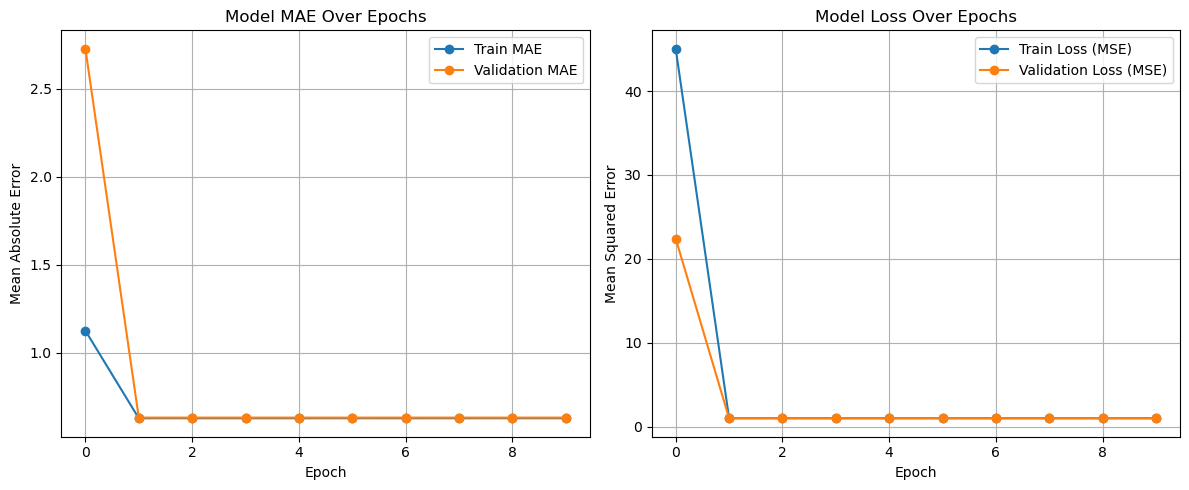


Evaluating the model on the test set...
Test Loss (MSE): 0.999882161617279
Test MAE: 0.6314675807952881

Generating evaluation plots...
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 311ms/step
Predictions shape: (623, 2)


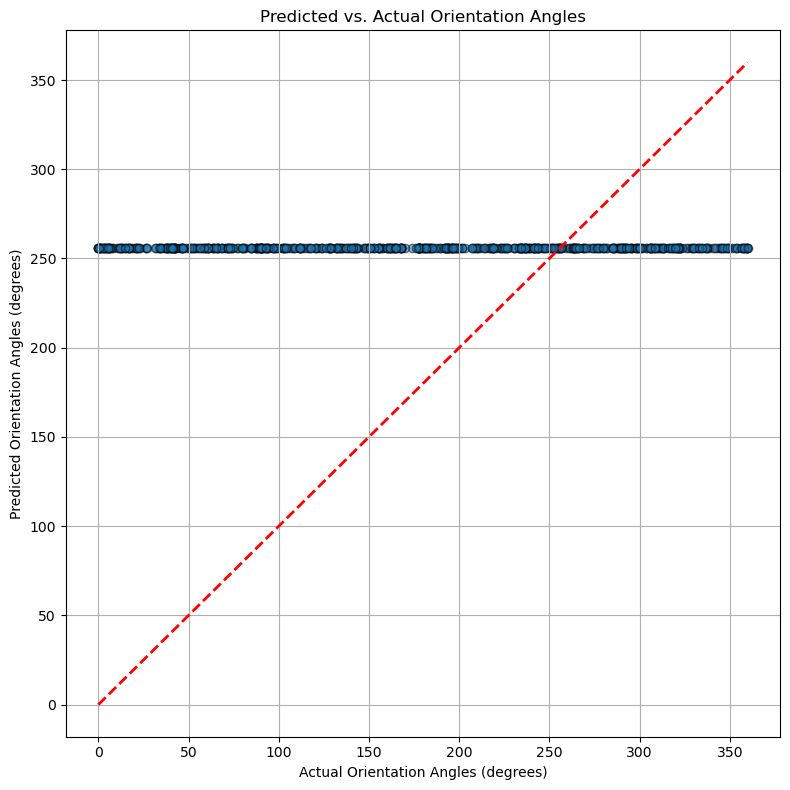

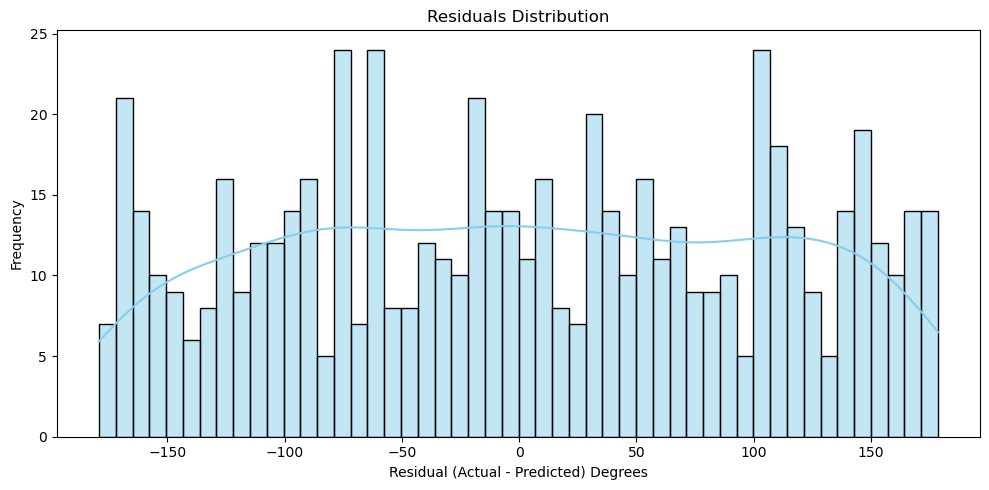


Mean Absolute Error (MAE): 106.43 degrees
Root Mean Squared Error (RMSE): 130.60 degrees
R-squared (R²): -0.58


/var/folders/tt/1l08355d2tb87jgn9r18nm4r0000gn/T/ipykernel_15907/227029242.py:286: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


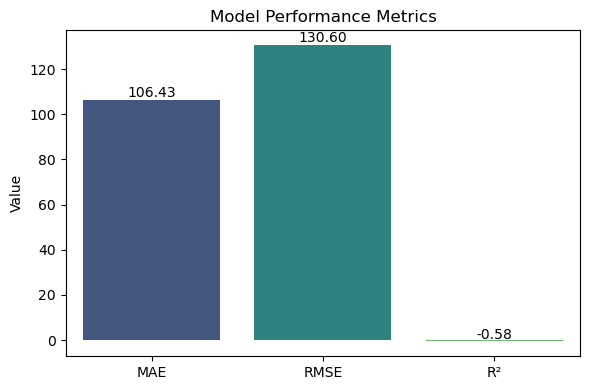

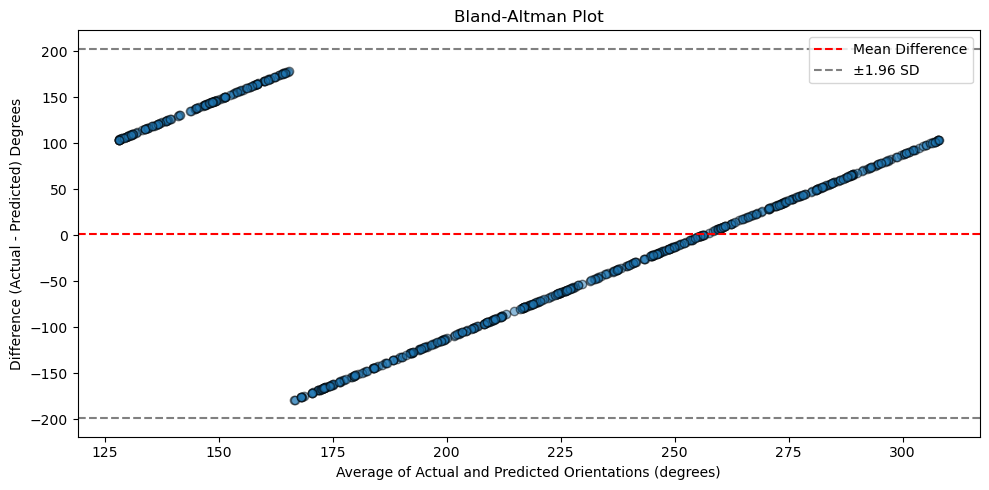

Bland-Altman plot generated.

Evaluation complete.


In [3]:
def get_run_prefixes():
    """Generate run prefixes for s05 and s14 runs."""
    s05 = [f"s05_run{str(i).zfill(3)}" for i in range(1, 13)]  # s05_run001 to s05_run012
    s14 = [f"s14_run{str(i).zfill(3)}" for i in range(2, 13)]  # s14_run002 to s14_run012
    return s05 + s14

def match_files(input_dir, output_dir, prefixes):
    """Match NIfTI files with their corresponding CSV label files."""
    matched = []
    for prefix in prefixes:
        nifti_path = os.path.join(input_dir, f"{prefix}.nii")
        csv_path = os.path.join(output_dir, f"{prefix}_orientations.csv")
        if os.path.isfile(nifti_path) and os.path.isfile(csv_path):
            matched.append((nifti_path, csv_path))
            print(f"Matched: {nifti_path} <--> {csv_path}")
        else:
            print(f"Warning: Missing file for prefix '{prefix}'")
    return matched

def load_data(input_dir, output_dir, prefixes, required_columns):
    """Load data and extract specified 3D volumes with corresponding labels."""
    X = []  # List to store 3D volumes
    y = []  # List to store orientation labels
    
    for nifti_path, csv_path in match_files(input_dir, output_dir, prefixes):
        try:
            # Load NIfTI data
            nii_img = nib.load(nifti_path)
            data = nii_img.get_fdata()
            print(f"Loaded NIfTI: {nifti_path} with shape {data.shape}")
            
            # Load CSV labels
            labels_df = pd.read_csv(csv_path)
            print(f"Loaded CSV: {csv_path} with {len(labels_df)} entries")
            
            # Validate CSV columns
            if not required_columns.issubset(labels_df.columns):
                print(f"Error: Missing columns in {csv_path}. Required columns: {required_columns}")
                continue
            
            # Extract 'Volume Index' and 'Orientation'
            volume_indices = labels_df['Volume Index'].values
            orientations = labels_df['Orientation'].values
            
            # Validate volume indices
            max_index = data.shape[3] - 1
            if np.any(volume_indices > max_index) or np.any(volume_indices < 0):
                print(f"Error: Volume indices in {csv_path} are out of bounds for {nifti_path}")
                continue
            
            # Extract specified volumes using numpy.take for efficiency
            extracted_volumes = np.take(data, volume_indices, axis=3)  # Shape: (96, 96, 20, 328)
            print(f"Extracted volumes shape: {extracted_volumes.shape}")
            
            # Transpose to (328, 96, 96, 20)
            extracted_volumes = np.transpose(extracted_volumes, (3, 0, 1, 2))  # Shape: (328, 96, 96, 20)  # Treat each as an independent sample
            
            # Add channel dimension to make it (328, 96, 96, 20, 1)
            extracted_volumes = extracted_volumes[..., np.newaxis]
            print(f"Reshaped volumes for CNN: {extracted_volumes.shape}")
            
            # Append to X and y
            X.append(extracted_volumes)
            y.append(orientations)
            
            print(f"Successfully extracted and reshaped {len(orientations)} samples from {nifti_path} and {csv_path}\n")
        except Exception as e:
            print(f"Error processing {nifti_path} and {csv_path}: {e}")
            continue
    
    # Concatenate all matched samples (X input with y "Orientation label")
    if X:
        X = np.concatenate(X, axis=0)  # Shape: (total_samples, 96, 96, 20, 1)
        y = np.concatenate(y, axis=0)  # Shape: (total_samples,)
    else:
        X = np.array([]).reshape(0, 96, 96, 20, 1)
        y = np.array([])
        print("No data was loaded. Please check your input directories and file formats.")
    
    print(f"Final X shape: {X.shape}")
    print(f"Final y shape: {y.shape}")
    
    return X, y

def build_model(input_shape):
    """Builds and returns a 3D CNN regression model with Batch Normalization."""
    model = Sequential()
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='linear'))  # Output layer with 2 neurons for sin and cos
    return model

def combined_loss(y_true, y_pred):
    """Combined MSE loss for sin and cos predictions."""
    loss1 = tf.keras.losses.MSE(y_true[:,0], y_pred[:,0])
    loss2 = tf.keras.losses.MSE(y_true[:,1], y_pred[:,1])
    return loss1 + loss2

def plot_orientation_distribution_with_hex_wave(y):
    """
    Plots the distribution of orientation labels with a 6-fold hexagonal oscillation overlay.
    """
    plt.figure(figsize=(10, 6))

    # Plot the histogram
    ax1 = plt.gca()
    sns.histplot(y, bins=60, kde=False, color='skyblue', alpha=0.6, edgecolor='black')
    plt.title('Distribution of Orientation Labels with Hexagonal Oscillation')
    plt.xlabel('Orientation Angle (degrees)')
    plt.ylabel('Frequency')

    # Generate degrees for the overlay
    degrees = np.linspace(0, 360, 1000)
    hex_wave = 80 * (np.cos(np.radians(degrees * 6 - 30)) + 1) / 2  # Normalized and scaled

    # Plot the hexagonal oscillation
    plt.plot(degrees, hex_wave, color='red', linewidth=2)
    plt.tight_layout()
    plt.show()

def main():
    # Define the input and output directories
    input_dir = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT'
    output_dir = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation'
    
    # Define the required columns in the CSV files
    required_columns = {'Volume Index', 'Volume Start Time (s)', 'Label Time (s)', 'Orientation'}
    
    # Get the list of run prefixes
    prefixes = get_run_prefixes()
    
    # Load the data
    X, y = load_data(input_dir, output_dir, prefixes, required_columns)
    print(f"Total samples: {X.shape[0]}, Volume shape: {X.shape[1:]}, Labels shape: {y.shape}")
    
    if X.shape[0] == 0:
        print("No data available for training. Exiting.")
        return
    
    # Plot LABEL DISTRIBUTION with 6-fold hexagonal oscillation overlay
    plot_orientation_distribution_with_hex_wave(y)

    # Split the data into training and testing sets
    print("\nSplitting data into training and testing sets (80% training, 20% testing)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )
    print(f"Number of samples in training set: {X_train.shape[0]}")
    print(f"Number of samples in testing set: {X_test.shape[0]}")

    print("\nNormalizing fMRI data using z-scoring...")
    # Compute mean and std from training data
    mean = X_train.mean()
    std = X_train.std()
    print(f"Training data mean: {mean}, std: {std}")
    
    # Normalize training and testing data
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    print("Data normalization complete.")

    # Convert angles to radians and compute sin and cos
    y_train_rad = np.radians(y_train)
    y_test_rad = np.radians(y_test)
    
    y_train_sin = np.sin(y_train_rad)
    y_train_cos = np.cos(y_train_rad)
    y_test_sin = np.sin(y_test_rad)
    y_test_cos = np.cos(y_test_rad)
    
    y_train_transformed = np.stack([y_train_sin, y_train_cos], axis=1)
    y_test_transformed = np.stack([y_test_sin, y_test_cos], axis=1)
    
    print("\nDefining the 3D CNN regression model...")
    input_shape = X_train.shape[1:]  # Should be (96, 96, 20, 1)
    model = build_model(input_shape)
    model.summary()
    
    # Compile the model with a suitable optimizer and loss function
    model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=combined_loss, 
              metrics=[MeanAbsoluteError()])
    print("Model compiled successfully with a learning rate of 0.001.")

    print("\nTraining the 3D CNN regression model...")  
    history = model.fit(
        X_train, y_train_transformed,
        validation_data=(X_test, y_test_transformed),
        epochs=10,  # Increased epochs to allow better learning
        batch_size=6,
        verbose=1,
    )

    print("\nPlotting training history...")
    plt.figure(figsize=(12, 5))
    
    # Plot Mean Absolute Error (MAE)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mean_absolute_error'], label='Train MAE', marker='o')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', marker='o')
    plt.title('Model MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    
    # Plot Loss (Mean Squared Error)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss (MSE)', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', marker='o')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\nEvaluating the model on the test set...")
    test_loss, test_mae = model.evaluate(X_test, y_test_transformed, verbose=0)
    print(f"Test Loss (MSE): {test_loss}")
    print(f"Test MAE: {test_mae}")
    
    print("\nGenerating evaluation plots...")
    
    # Generate predictions
    predictions = model.predict(X_test, batch_size=5)
    print(f"Predictions shape: {predictions.shape}")  # Should be (num_samples, 2)

    # Check if predictions have at least two columns
    if predictions.shape[1] < 2:
        raise ValueError(f"Expected predictions with at least 2 columns, but got {predictions.shape[1]}")

    predicted_angles = (np.degrees(np.arctan2(predictions[:,1], predictions[:,0])) % 360)

    # Actual angles
    actual_angles = y_test % 360
    
    # Scatter Plot: Predicted vs. Actual
    plt.figure(figsize=(8, 8))
    plt.scatter(actual_angles, predicted_angles, alpha=0.5, edgecolors='k')
    min_val = min(actual_angles.min(), predicted_angles.min())
    max_val = max(actual_angles.max(), predicted_angles.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel('Actual Orientation Angles (degrees)')
    plt.ylabel('Predicted Orientation Angles (degrees)')
    plt.title('Predicted vs. Actual Orientation Angles')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Residuals Distribution
    residuals = (actual_angles - predicted_angles + 180) % 360 - 180  # Circular residuals
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, bins=50, kde=True, color='skyblue')
    plt.title('Residuals Distribution')
    plt.xlabel('Residual (Actual - Predicted) Degrees')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    # Calculate additional metrics
    mae = mean_absolute_error(actual_angles, predicted_angles)
    rmse = np.sqrt(mean_squared_error(actual_angles, predicted_angles))
    # R² Score is not well-defined for circular data, interpret with caution
    r2 = r2_score(actual_angles, predicted_angles)
    
    print(f"\nMean Absolute Error (MAE): {mae:.2f} degrees")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f} degrees")
    print(f"R-squared (R²): {r2:.2f}")
    
    # Bar Plot for Error Metrics
    metrics = ['MAE', 'RMSE', 'R²']
    values = [mae, rmse, r2]
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x=metrics, y=values, palette='viridis')
    plt.title('Model Performance Metrics')
    plt.ylabel('Value')
    for index, value in enumerate(values):
        plt.text(index, value + 0.01 * max(values), f"{value:.2f}", ha='center')
    plt.tight_layout()
    plt.show()
    
    # Bland-Altman Plot
    average = (actual_angles + predicted_angles) / 2
    difference = residuals  # Already circular residuals
    
    plt.figure(figsize=(10, 5))
    plt.scatter(average, difference, alpha=0.5, edgecolors='k')
    mean_diff = np.mean(difference)
    std_diff = np.std(difference)
    plt.axhline(mean_diff, color='red', linestyle='--', label='Mean Difference')
    plt.axhline(mean_diff + 1.96*std_diff, color='gray', linestyle='--', label='±1.96 SD')
    plt.axhline(mean_diff - 1.96*std_diff, color='gray', linestyle='--')
    plt.xlabel('Average of Actual and Predicted Orientations (degrees)')
    plt.ylabel('Difference (Actual - Predicted) Degrees')
    plt.title('Bland-Altman Plot')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("Bland-Altman plot generated.")
    
    print("\nEvaluation complete.")

if __name__ == "__main__":
    main()
